# Sensor Based Activity Recoginition 
Challenge: cdl1 - Sensor based Activity Recognition  
Team: Lea Bütler, Manjavy Kirupa, Etienne Roulet, Si Ben Tran  

Aufgabe: DL Modell erstellen

Hier in diesem Notebook erstellen wir unsere Deep Learning Modelle.

In [10]:
import tensorflow as tf
print(tf.config.list_physical_devices())
tf.debugging.set_log_device_placement(False)


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [11]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: scikit-learn in c:\python311\lib\site-packages (1.2.1)




[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:

import logging
from datetime import datetime
# datetime as filename for logging
now = datetime.now()
date_time_string = now.strftime("%Y-%m-%d_%H-%M-%S")

logging.basicConfig(level=logging.INFO, filename = f"{date_time_string}.txt", filemode='a')

In [14]:

from dataclasses import dataclass

@dataclass
class Parameters():
    batch_size: int = 128
    epochs: int = 10
    verbosity: int = 1
    step_size: int = 374
    number_folds: int = 2
    output_size: int = 6
    

In [15]:
# Loading Data
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection as ms

# read the CSV file into a DataFrame
df = pd.read_csv("Alle_Messungen_trimmed.csv")
df.head(1)

,Unnamed: 0,time,Accelerometer_x,Accelerometer_y,Accelerometer_z,Gyroscope_x,Gyroscope_y,Gyroscope_z,Magnetometer_x,Magnetometer_y,Magnetometer_z,Orientation_qx,Orientation_qy,Orientation_qz,id,user,class,id_combined
0,1,2023-02-27 15:02:17.156,0.0,9.722,1.278,0.0,0.0,0.0,0.0,0.0,0.0,-0.21775,-0.719579,0.631111,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen


In [16]:
df = df.drop(columns=["id", "user", "id_combined"])
df.drop(['Unnamed: 0'], axis=1, inplace=True)
# get all types of the df
df['time'] = pd.to_datetime(df['time'])
df['time'] = df['time'].astype('int64')//1e9
le = LabelEncoder()
df["class"] = le.fit_transform(df["class"])


In [17]:
def factors(n):
    result = set()
    for i in range(1, int(n**0.5) + 1):
        div, mod = divmod(n, i)
        if mod == 0:
            result |= {i, div}
    return result


In [18]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

X = df.values[:, 1:13]
y = df.values[:, 13]

# Reshape X to 3D format (samples, timesteps, features)
timesteps = 1  # You can choose a different number of timesteps based on the nature of your data
n_features = X.shape[1]
X = X.reshape(-1, timesteps, n_features)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=6)
y_test = to_categorical(y_test, num_classes=6)


In [19]:
#X_train, X_test, y_train, y_test = ms.train_test_split(df.values[:, 1:13], df.values[:, 13], test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42)

#dataset = tf.data.Dataset.from_tensor_slices((df.values[:, 1:13], df.values[:, 13]))

In [20]:
# Template
import tensorflow as tf
from sklearn.model_selection import KFold
import numpy as np
import dataclasses

# Load data and preprocess
# split train dataset into x_train and y_train
x_train = X_train
x_test = X_test
y_train = y_train
y_test = y_test
    

# Something like this as first Model
def create_model_1():
    model = tf.keras.Sequential([
            tf.keras.layers.Dense(16, activation='relu', input_shape=(12,)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(8, activation='relu', input_shape=(12,)),
            tf.keras.layers.Dense(6, activation='softmax')
    ])
    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
    return model


# Something like this as second Model
def create_model_2():
    model = tf.keras.Sequential([
        tf.keras.layers.Reshape((-1, 12), input_shape=(12,)),
        tf.keras.layers.Conv1D(32, 5, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv1D(16, 3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
    return model

# Something like this as Third Model
def create_model_3():
    model = tf.keras.Sequential([
        tf.keras.layers.Reshape((-1, 12), input_shape=(12,)),
        tf.keras.layers.Conv1D(32, 5, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv1D(16, 3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
    return model

def create_model_4():
    model = tf.keras.Sequential([
        # Add a 1D convolutional layer
        tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', padding='same', input_shape=(timesteps, n_features)),
        
        # Add LSTM layer
        tf.keras.layers.LSTM(100),

        # Add a dense output layer
        tf.keras.layers.Dense(6, activation='softmax')  # Change activation function based on the nature of the output
    ])
    model.compile(optimizer='adam',   loss='categorical_crossentropy', metrics=['accuracy'])  # Change the loss function based on the nature of the output
    return model

best_model_history = None  # Keep track of the best model's history
model_histories = []
# Perform cross-validation
models = [create_model_4]
best_model = None
num_folds = Parameters.number_folds
kfold = KFold(n_splits=num_folds, shuffle=True)
fold_acc_scores = []

for i, (train, test) in enumerate(kfold.split(x_train, y_train)):
    logging.info(f'Fold {i+1}')
    train_x, train_y = x_train[train], y_train[train]
    test_x, test_y = x_train[test], y_train[test]
    
    fold_histories = []

    
    for j, model_creator in enumerate(models):
        model = model_creator()
        logging.info(f'Model {j+1}')
        history = model.fit(train_x, train_y, epochs=Parameters.epochs, batch_size=Parameters.batch_size, validation_data=(test_x, test_y), verbose=Parameters.verbosity)
        test_loss, acc = model.evaluate(test_x, test_y, verbose=Parameters.verbosity)
        logging.info(f'Validation accuracy: {acc}')
        
        fold_histories.append(history.history)
        
        for epoch in range(Parameters.epochs):
            # Log accuracy after each epoch
            acc_epoch = history.history['val_accuracy'][epoch]
            logging.info(f'Epoch {epoch + 1}, Validation accuracy: {acc_epoch}')
        fold_acc_scores.append((i, j, acc))
        
        if best_model_history is None or acc > best_model_acc:
            best_model_history = history
            best_model = model  # Store the trained model instance
            best_model_acc = acc
    
    model_histories.append(fold_histories)

# Find the best model
best_model_index = np.argmax([score[2] for score in fold_acc_scores])
best_fold_idx, best_model_idx, _ = max(fold_acc_scores, key=lambda x: x[2])
best_model_history = model_histories[best_fold_idx][best_model_idx]


#ogging.info(fold_acc_scores)
#logging.info(best_model_index)
#(best_fold, best_model_index, best_model_acc) = fold_acc_scores[best_model_index]
#best_model = models[best_model_index]
#logging.info(f'fold acc score: {fold_acc_scores}')
#logging.info(f'Best model is model {best_model_index+1}')

# Evaluate the best model on the test set
test_loss, test_acc = best_model.evaluate(x_test, y_test)
logging.info(f'Test accuracy {test_acc}')

Epoch 1/10
8000/8000 [==============================] - 42s 5ms/step - loss: 0.3738 - accuracy: 0.8699 - val_loss: 0.2437 - val_accuracy: 0.9164
Epoch 2/10
8000/8000 [==============================] - 40s 5ms/step - loss: 0.2079 - accuracy: 0.9292 - val_loss: 0.1866 - val_accuracy: 0.9370
Epoch 3/10
8000/8000 [==============================] - 36s 5ms/step - loss: 0.1691 - accuracy: 0.9427 - val_loss: 0.1647 - val_accuracy: 0.9437
Epoch 4/10
8000/8000 [==============================] - 37s 5ms/step - loss: 0.1503 - accuracy: 0.9493 - val_loss: 0.1499 - val_accuracy: 0.9495
Epoch 5/10
8000/8000 [==============================] - 39s 5ms/step - loss: 0.1377 - accuracy: 0.9535 - val_loss: 0.1400 - val_accuracy: 0.9525
Epoch 6/10
8000/8000 [==============================] - 40s 5ms/step - loss: 0.1288 - accuracy: 0.9564 - val_loss: 0.1334 - val_accuracy: 0.9549
Epoch 7/10
8000/8000 [==============================] - 39s 5ms/step - loss: 0.1218 - accuracy: 0.9587 - val_loss: 0.1260 - val_ac

In [21]:
model_histories

[[{'loss': [0.3737727701663971,
    0.20794881880283356,
    0.16910861432552338,
    0.15026721358299255,
    0.1377463936805725,
    0.1288413107395172,
    0.12181305140256882,
    0.11614194512367249,
    0.11240524053573608,
    0.10832643508911133],
   'accuracy': [0.869893491268158,
    0.9292250275611877,
    0.942670464515686,
    0.9492955207824707,
    0.9535328149795532,
    0.9564352035522461,
    0.9587457776069641,
    0.9607663154602051,
    0.9618424773216248,
    0.9633219838142395],
   'val_loss': [0.24373289942741394,
    0.18656888604164124,
    0.16469846665859222,
    0.14994318783283234,
    0.1400148570537567,
    0.1333574503660202,
    0.1260184347629547,
    0.12191760540008545,
    0.12179628014564514,
    0.11670263856649399],
   'val_accuracy': [0.9163539409637451,
    0.9369800090789795,
    0.94365394115448,
    0.949455738067627,
    0.9524986743927002,
    0.9549078941345215,
    0.9580202102661133,
    0.9595680832862854,
    0.9592116475105286,
    

[0.38682350516319275, 0.21463936567306519, 0.1756785660982132, 0.1552341729402542, 0.14175163209438324, 0.13308559358119965, 0.12505704164505005, 0.11946100741624832, 0.11475060880184174, 0.11082107573747635]


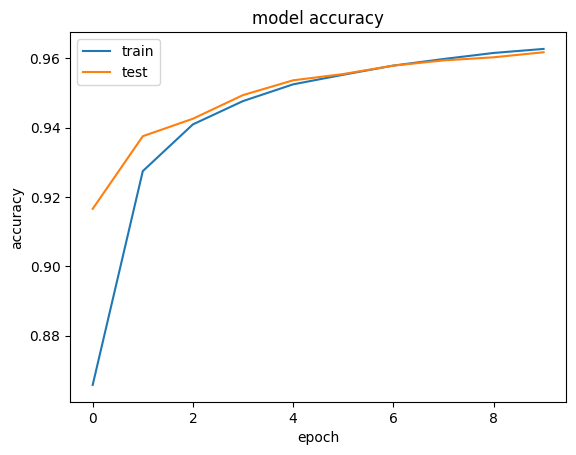

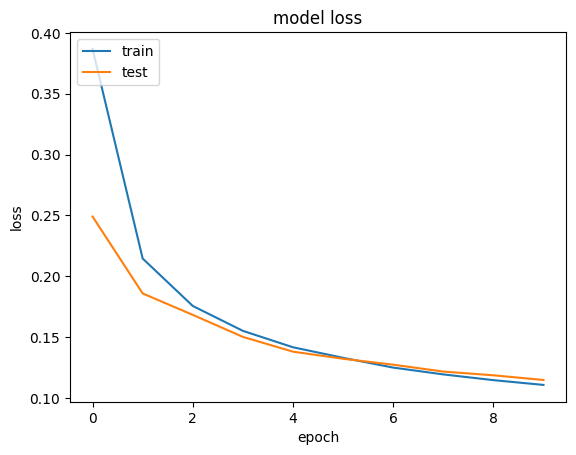

In [26]:

import matplotlib.pyplot as plt
import numpy as np

print(best_model_history['loss'])
# summarize history for accuracy
plt.plot(best_model_history['accuracy'])
plt.plot(best_model_history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(best_model_history['loss'])
plt.plot(best_model_history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Create a Baseline Model

In [ ]:
# Compare Baseline vs best_model

In [ ]:
# plot graph for learning curve and loss curve from baseline and best_model

In [ ]:
# summarise best model
best_model.summary()


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_22 (Conv1D)          (None, 1, 64)             1600      
                                                                 
 lstm_10 (LSTM)              (None, 100)               66000     
                                                                 
 dense_16 (Dense)            (None, 6)                 606       
                                                                 
Total params: 68,206
Trainable params: 68,206
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# print loss and accuracy for best model over epoch and steps plot

In [ ]:
y_pred = model.predict(X_test)

16000/16000 [==============================] - 10s 603us/step


In [ ]:
model.evaluate(X_test, y_test)

16000/16000 [==============================] - 11s 710us/step - loss: 0.2796 - accuracy: 0.9057


[0.27957311272621155, 0.9057142734527588]

In [ ]:
# plot a confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot()
plt.show()

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

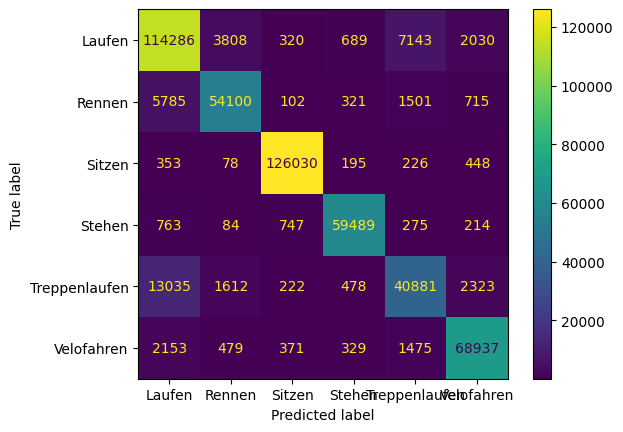

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_test_labels = y_test.argmax(axis=1)
y_pred_labels = y_pred.argmax(axis=1)

cm = confusion_matrix(y_test_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot()
plt.show()


In [ ]:
# Export Model for using in tensorflow.js
!mkdir -p saved_model
best_model.save('saved_model/sensor_model')
best_model.save('saved_model/sensor_model.h5')

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file saved_model already exists.
Error occurred while processing: saved_model.


INFO:tensorflow:Assets written to: saved_model/sensor_model\assets


In [ ]:
# Save the weight for the Js Model
best_model.save_weights('./checkpoints/my_checkpoint')


In [ ]:
# upload model to server to download it on tensorflow js

In [ ]:
dill.dump_session('notebook_env.db')

NameError: name 'dill' is not defined